In [1]:
# Importing Necessary Packages 

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set Global Values
LEARNING_RATE = 1e-5
EPOCHS = 15
BATCH_SIZE = 32
OPTR = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / EPOCHS)

In [3]:
# Retrieve data from disc

x = np.load('X_RAW.npy')
Y = np.load('Y_RAW.npy')

print(x.shape)
print(Y.shape)

(3833, 100, 100, 3)
(3833, 2)


In [4]:
# Split the data into Train/Dev set
# Using Train/Dev ratio as 4:1

x_train, x_test, Y_train, Y_test = train_test_split(x, Y,
                                                    test_size=0.2, stratify=Y,
                                                    random_state=9
                                                   )
print('Training Set [x, Y]', x_train.shape, Y_train.shape)
print('Dev Set [x, Y]', x_test.shape, Y_test.shape)

Training Set [x, Y] (3066, 100, 100, 3) (3066, 2)
Dev Set [x, Y] (767, 100, 100, 3) (767, 2)


In [9]:
# Lets Start Defining Our Model

# Load the MobileNetV2 model excluding the Fully Connected Top Layer
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(100, 100, 3))
                       )

# Create Fully connected layers to be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3,3), padding='valid')(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(32, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

# Combine baseModel and headModel
model = Model(inputs=baseModel.input, outputs=headModel)

# Freezing all layers of the baseModel
for layer in baseModel.layers:
    layer.trainable = False
model.compile(loss='binary_crossentropy', optimizer=OPTR, metrics=['accuracy'])

In [10]:
DeepFace = model.fit(x_train, Y_train, batch_size=BATCH_SIZE,
                     steps_per_epoch = len(x_train) // BATCH_SIZE,
                     validation_data=(x_test, Y_test),
                     validation_steps = len(x_test) // BATCH_SIZE,
                     epochs=EPOCHS
                    )

Epoch 1/15
95/95 [==============================] - 23s 246ms/step - loss: 1.1429 - accuracy: 0.5704 - val_loss: 0.6385 - val_accuracy: 0.6726
Epoch 2/15
95/95 [==============================] - 23s 238ms/step - loss: 0.8665 - accuracy: 0.6493 - val_loss: 0.4989 - val_accuracy: 0.7609
Epoch 3/15
95/95 [==============================] - 23s 237ms/step - loss: 0.7185 - accuracy: 0.7024 - val_loss: 0.4047 - val_accuracy: 0.8166
Epoch 4/15
95/95 [==============================] - 22s 237ms/step - loss: 0.5778 - accuracy: 0.7442 - val_loss: 0.3403 - val_accuracy: 0.8492
Epoch 5/15
95/95 [==============================] - 22s 237ms/step - loss: 0.5021 - accuracy: 0.7729 - val_loss: 0.2956 - val_accuracy: 0.8818
Epoch 6/15
95/95 [==============================] - 23s 237ms/step - loss: 0.4292 - accuracy: 0.8144 - val_loss: 0.2624 - val_accuracy: 0.8954
Epoch 7/15
95/95 [==============================] - 22s 236ms/step - loss: 0.3850 - accuracy: 0.8336 - val_loss: 0.2360 - val_accuracy: 0.9035

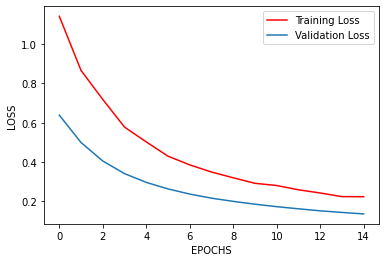

In [11]:
plt.plot(DeepFace.history['loss'],'r',label='Training Loss')
plt.plot(DeepFace.history['val_loss'],label='Validation Loss')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()

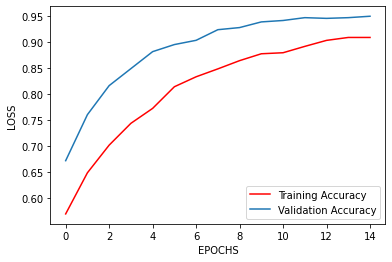

In [12]:
plt.plot(DeepFace.history['accuracy'],'r',label='Training Accuracy')
plt.plot(DeepFace.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()

In [13]:
model.save('DeepFaceMask.model', save_format="h5")